In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 500)
import tabula
from pandasql import sqldf
import math
from scipy.stats import chi2
from scipy import stats
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import tukey_hsd
import pingouin as pg

In [2]:
# import dataset
titles = pd.read_csv(r"C:\Users\edwar\Desktop\Melbourne\semester1\elements_of_data_processing\assignment2\titles.csv")
movie_data_v1 = pd.read_csv(r"C:\Users\edwar\Desktop\Melbourne\semester1\elements_of_data_processing\assignment2\movie_data_intactversion.csv")
credits = pd.read_csv(r"C:\Users\edwar\Desktop\Melbourne\semester1\elements_of_data_processing\assignment2\credits.csv")

In [5]:
# see the number of instances for each category of age certification
titles['age_certification'].value_counts()

TV-MA    883
R        556
TV-14    474
PG-13    451
PG       233
TV-PG    188
G        124
TV-Y7    120
TV-Y     107
TV-G      79
NC-17     16
Name: age_certification, dtype: int64

In [4]:
# delete some vaiables
movie_data_abb = movie_data_v1.iloc[:, :6]

# split dataset
movie_data_age = movie_data_abb[['age_certification', 'tmdb_popularity']]
movie_data_genres = movie_data_abb[['genres', 'tmdb_popularity', 'imdb_votes']]

### age_certification vs popularity

In [5]:
# using log2() to adjust the popularity
movie_data_age['tmdb_popularity_adj'] = np.log2(movie_data_age['tmdb_popularity'])
movie_data_age.loc[movie_data_age['tmdb_popularity_adj'] < 0, 'tmdb_popularity_adj'] = 0
movie_data_age_v1 = movie_data_age[movie_data_age['tmdb_popularity_adj'].isna() == False].reset_index().drop(['index'], axis = 1)
movie_data_age_v1 = movie_data_age_v1[movie_data_age_v1['age_certification'].isna() == False].reset_index().drop(['index'], axis = 1)

C:\Users\edwar\AppData\Local\Temp\ipykernel_13432\3883544798.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_data_age['tmdb_popularity_adj'] = np.log2(movie_data_age['tmdb_popularity'])


In [6]:
# see the mean of popularity of each age certification
mean_summary = movie_data_age_v1.groupby(by = ['age_certification']).agg({'tmdb_popularity_adj':'mean'})
mean_summary

,tmdb_popularity_adj
age_certification,
G,2.285004
NC-17,3.837902
PG,3.452113
PG-13,3.679748
R,4.056666
TV-14,3.452012
TV-G,3.352476
TV-MA,3.390366
TV-PG,2.793306


In [7]:
# multiple testing
def age_popu(types):
    return np.array(movie_data_age_v1[movie_data_age_v1['age_certification'] == types].reset_index()['tmdb_popularity_adj'])
movie_G = age_popu('G')
movie_NC17 = age_popu('NC-17')
movie_PG = age_popu('PG')
movie_PG13 = age_popu('PG-13')
movie_R = age_popu('R')
movie_TV14 = age_popu('TV-14')
movie_TVG = age_popu('TV-G')
movie_TVMA = age_popu('TV-MA')
movie_TVPG = age_popu('TV-PG')
movie_TVY = age_popu('TV-Y')
movie_TVY7 = age_popu('TV-Y7')

In [8]:
f_statistic, p_value = stats.f_oneway(movie_G, movie_NC17, movie_PG, movie_PG13, movie_R, movie_TV14, movie_TVG, movie_TVMA, 
                                      movie_TVPG, movie_TVY, movie_TVY7)
print('F-test outcomes: p-value = {}'.format(p_value))

F-test outcomes: p-value = 3.5653915835930953e-32


In [9]:
# it's statsitically significant, so we conduct post-hoc test with tuckey methods.
tukey_results = tukey_hsd(movie_G, movie_NC17, movie_PG, movie_PG13, movie_R, movie_TV14, movie_TVG, movie_TVMA, movie_TVPG, movie_TVY, movie_TVY7)

In [10]:
print(tukey_results)

Tukey's HSD Pairwise Group Comparisons (95.0% Confidence Interval)
Comparison  Statistic  p-value  Lower CI  Upper CI
 (0 - 1)     -1.553     0.055    -3.122     0.017
 (0 - 2)     -1.167     0.000    -1.836    -0.498
 (0 - 3)     -1.395     0.000    -2.008    -0.782
 (0 - 4)     -1.772     0.000    -2.372    -1.171
 (0 - 5)     -1.167     0.000    -1.778    -0.556
 (0 - 6)     -1.067     0.003    -1.926    -0.209
 (0 - 7)     -1.105     0.000    -1.687    -0.524
 (0 - 8)     -0.508     0.406    -1.208     0.191
 (0 - 9)     -0.066     1.000    -0.863     0.730
 (0 - 10)     -1.321     0.000    -2.089    -0.553
 (1 - 0)      1.553     0.055    -0.017     3.122
 (1 - 2)      0.386     0.999    -1.135     1.907
 (1 - 3)      0.158     1.000    -1.339     1.655
 (1 - 4)     -0.219     1.000    -1.711     1.274
 (1 - 5)      0.386     0.999    -1.111     1.882
 (1 - 6)      0.485     0.997    -1.128     2.099
 (1 - 7)      0.448     0.997    -1.037     1.932
 (1 - 8)      1.045     0.510  

<Figure size 1500x1000 with 0 Axes>

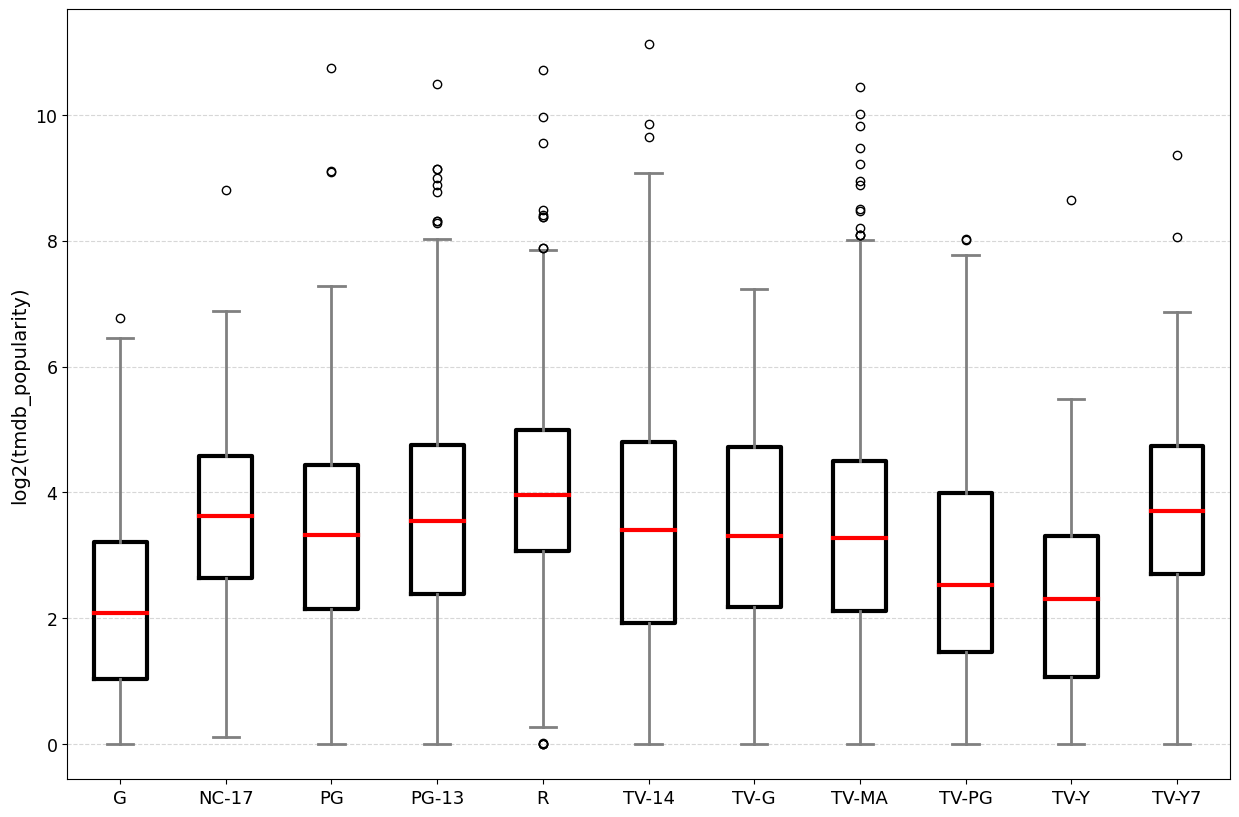

In [103]:
pop_data = [movie_G, movie_NC17, movie_PG, movie_PG13, movie_R, movie_TV14, movie_TVG, movie_TVMA, movie_TVPG, movie_TVY, movie_TVY7]
plt.figure(figsize = (15, 10))
label_lst = ['G', 'NC-17', 'PG', 'PG-13', 'R', 'TV-14', 'TV-G', 'TV-MA', 'TV-PG', 'TV-Y', 'TV-Y7']

fig, ax = plt.subplots(figsize=(15, 10))
pos = [i for i in range(len(pop_data))]

# beautify
boxprops = dict(linewidth = 3, color = 'black')  
medianprops = dict(linewidth = 3, color = 'red')  
whiskerprops = dict(linewidth = 2, color = 'gray')
capprops = dict(linewidth = 2, color = 'gray')
meanprops = dict(linewidth = 2, color = 'blue')


bplot = ax.boxplot(pop_data, positions = pos, labels = label_lst, boxprops = boxprops, medianprops = medianprops, whiskerprops = whiskerprops, capprops = capprops, meanprops = meanprops)
plt.yticks(fontsize = 12.5)
plt.ylabel('log2(tmdb_popularity)', fontsize = 14)
ax.grid(True, linestyle='--', alpha=0.5, axis = 'y')


plt.xticks(fontsize = 13)
# plt.savefig(r'C:\Users\edwar\Desktop\Melbourne\semester1\elements_of_data_processing\assignment2\fig2.jpg', dpi = 300)
plt.show()